In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import missingno as msno
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
store = pd.read_csv('./store.csv')

c:\Users\WenBi\anaconda3\envs\vs\lib\site-packages\IPython\core\interactiveshell.py:3221: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
train.info(), test.info(), store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date     

(None, None, None)

In [7]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


<AxesSubplot:>

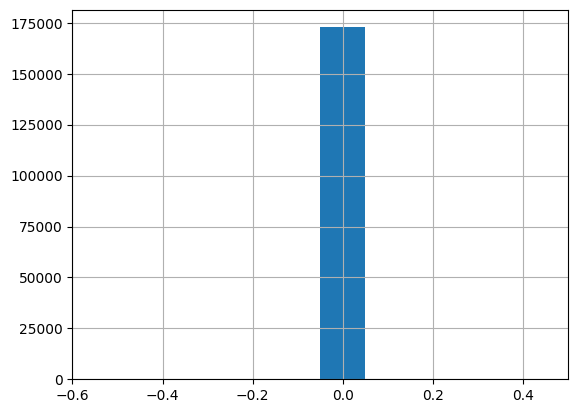

In [5]:
train.loc[train.Open==0].Sales.hist(align='left')

C:\Users\WenBi\AppData\Local\Temp\ipykernel_13404\3131977203.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train.loc[train.Open!=0].Sales)


The skewness of Sales is 1.5939220392699809


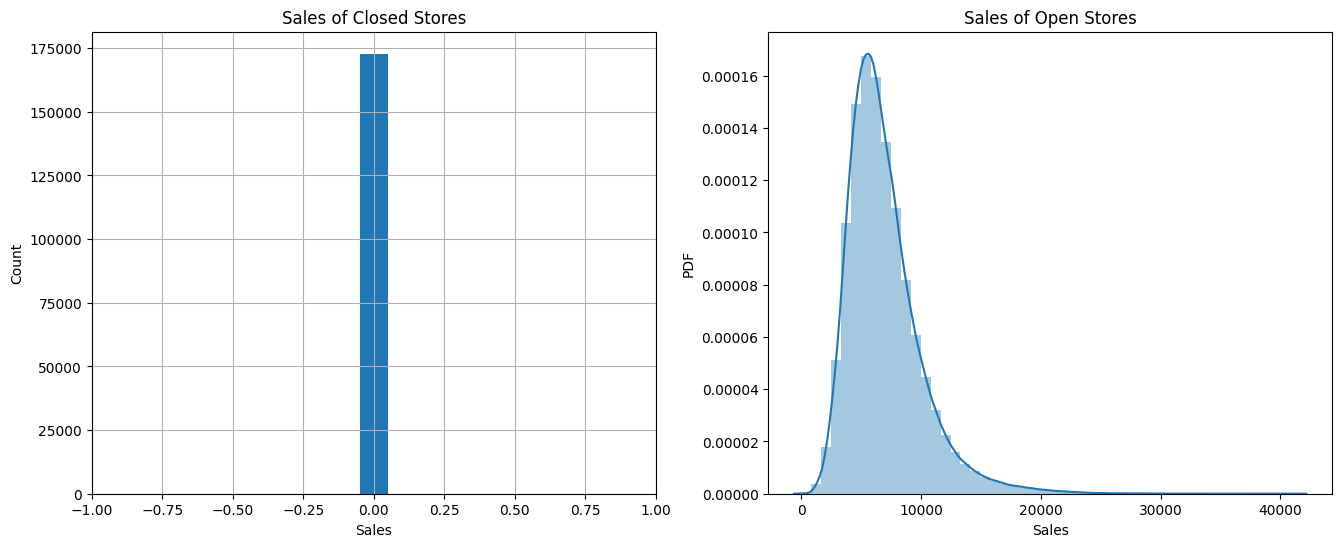

In [6]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Count')
ax1.set_title('Sales of Closed Stores')
plt.xlim(-1,1)
train.loc[train.Open==0].Sales.hist(align='left')
ax2 = fig.add_subplot(122)
ax2.set_xlabel('Sales')
ax2.set_ylabel('PDF')
ax2.set_title('Sales of Open Stores')
sns.distplot(train.loc[train.Open!=0].Sales)
print('The skewness of Sales is {}'.format(train.loc[train.Open!=0].Sales.skew()))

In [8]:
train = train.loc[train.Open != 0]
train = train.loc[train.Sales > 0].reset_index(drop=True)
train.shape

(844338, 9)

In [9]:
## 训练集的缺失信息：无缺失
train[train.isnull().values==True]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [10]:
## 测试集的缺失信息
test[test.isnull().values==True]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


<AxesSubplot:>

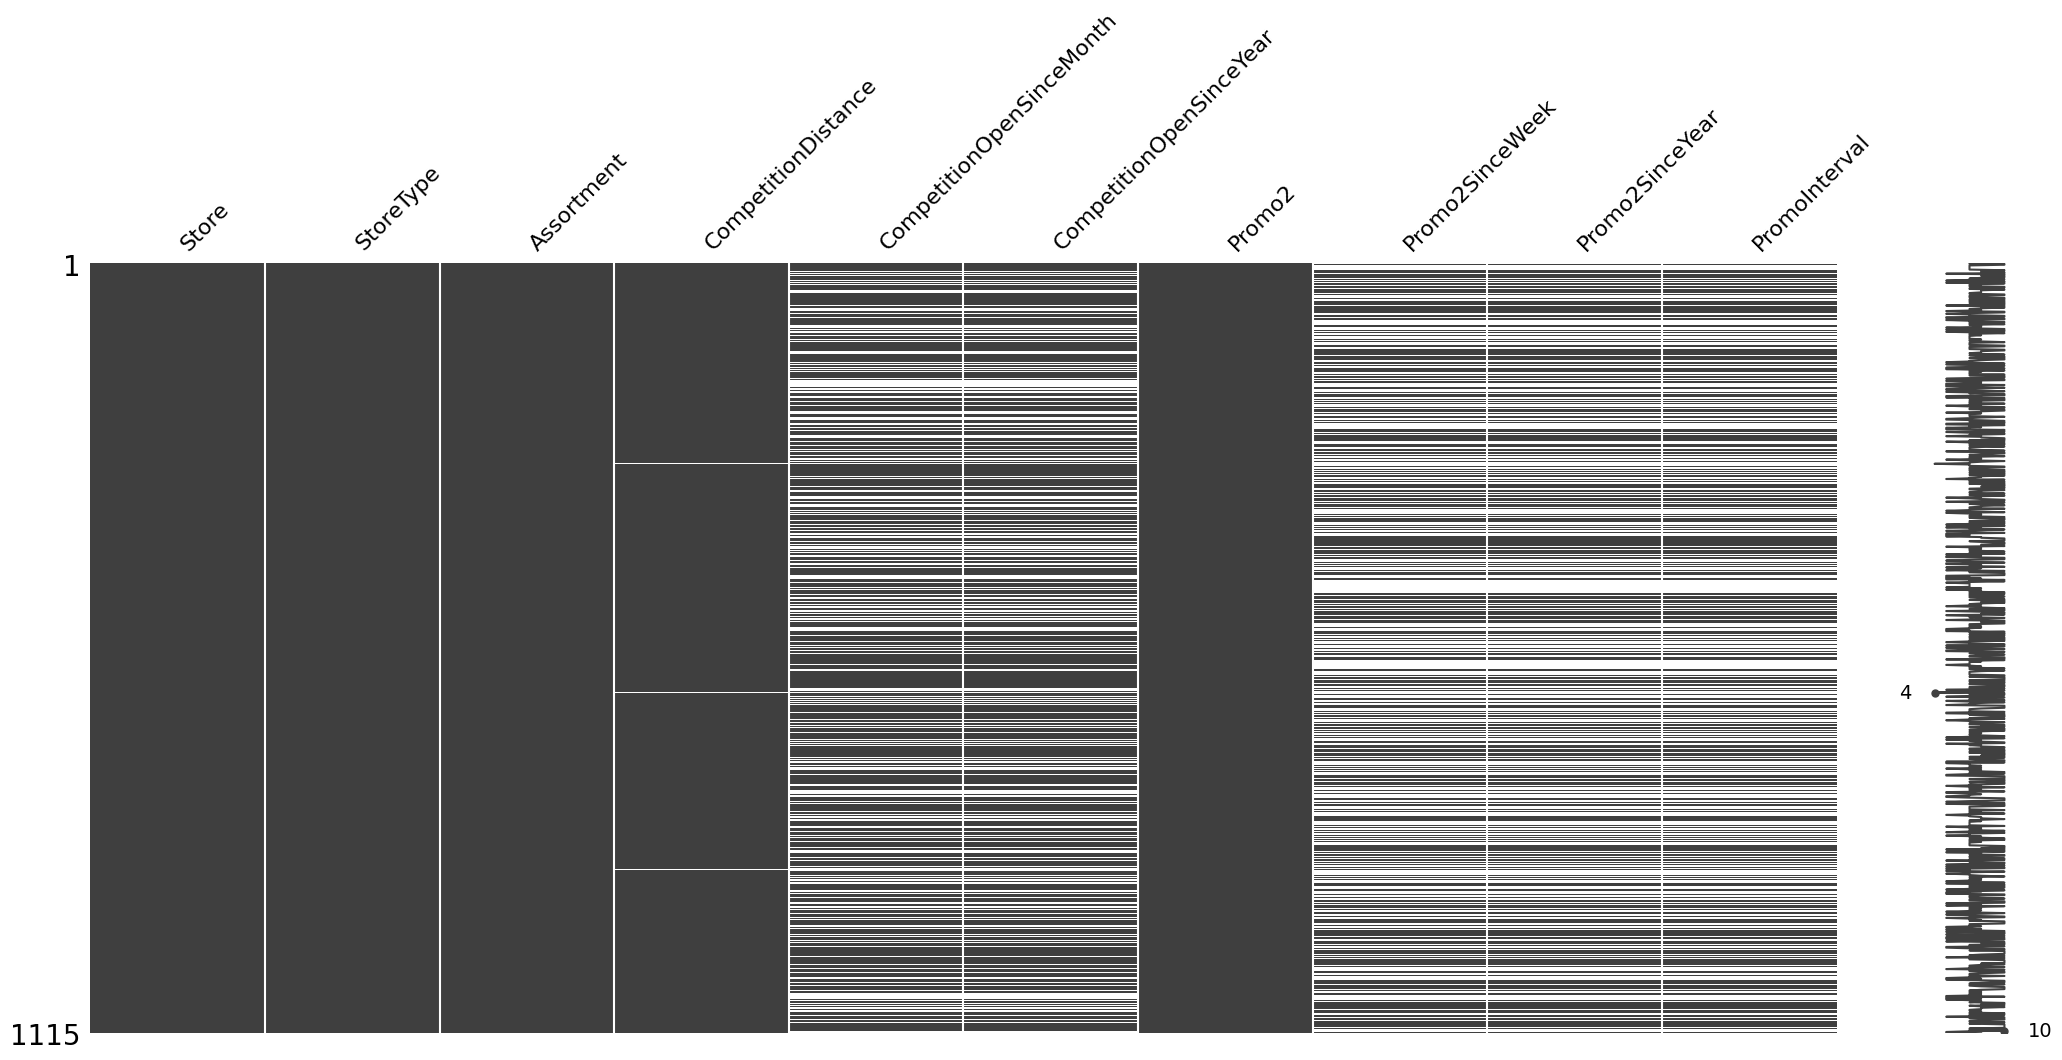

In [11]:
## store的缺失信息
msno.matrix(store)

In [12]:
## 默认test中的店铺全部正常营业
test.fillna(1,inplace=True)

## 对CompetitionDistance中的缺失值采用中位数进行填补
store.CompetitionDistance = store.CompetitionDistance.fillna(store.CompetitionDistance.median())

## 对其它缺失值全部补0
store.fillna(0,inplace=True)

In [13]:
## 特征合并
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [14]:
train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
5,1,6,2015-07-25,4364,500,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
6,1,5,2015-07-24,3706,459,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
7,1,4,2015-07-23,3769,503,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
8,1,3,2015-07-22,3464,463,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
9,1,2,2015-07-21,3558,469,1,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [15]:
def build_features(features, data):
    # 直接使用的特征
    features.extend(['Store','CompetitionDistance','CompetitionOpenSinceMonth','StateHoliday','StoreType','Assortment',
                     'SchoolHoliday','CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'])
    # 以下特征处理方式参考：https://blog.csdn.net/aicanghai_smile/article/details/80987666
    # 时间特征，抽取出年月日星期几等信息
    features.extend(['Year','Month','Day','DayOfWeek','WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    # 'CompetitionOpen'：竞争对手的已营业时间
    # 'PromoOpen'：竞争对手的已促销时间
    # 两个特征的单位均为月
    features.extend(['CompetitionOpen','PromoOpen'])
    data['CompetitionOpen'] = 12*(data.Year-data.CompetitionOpenSinceYear) + (data.Month-data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12*(data.Year-data.Promo2SinceYear) + (data.WeekOfYear-data.Promo2SinceWeek)/4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    # 'IsPromoMonth'：该天店铺是否处于促销月，1表示是，0表示否
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval==0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
    # 字符特征转换为数字
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    data['StoreType'] = data['StoreType'].astype(int)
    data['Assortment'] = data['Assortment'].astype(int)
    data['StateHoliday'] = data['StateHoliday'].astype(int)

In [16]:
## 处理Date方便特征提取
train.Date = pd.to_datetime(train.Date, errors='coerce')
test.Date = pd.to_datetime(test.Date, errors='coerce')
## 使用features数组储存使用的特征
features = []
## 对train与test特征提取
build_features(features, train)
build_features([], test)
## 打印使用的特征
print(features)

C:\Users\WenBi\AppData\Local\Temp\ipykernel_13404\428404604.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear


['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'StateHoliday', 'StoreType', 'Assortment', 'SchoolHoliday', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']


In [17]:
## 评价函数Rmspe
## 参考：https://www.kaggle.com/justdoit/xgboost-in-python-with-rmspe
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w
def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return rmspe
def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return "rmspe", rmspe
def neg_rmspe(yhat, y):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return -rmspe

In [20]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=2)
cv_sets = ShuffleSplit(n_splits=5, test_size=0.2)    
params = {'max_depth': range(10, 40, 2)}
scoring_fnc = make_scorer(neg_rmspe)
grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)
grid = grid.fit(train[features], np.log1p(train.Sales))
DTR = grid.best_estimator_


In [21]:
## 显示最佳超参数
DTR.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 30,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2,
 'splitter': 'best'}

In [22]:
## 生成上传文件
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(DTR.predict(test[features]))})
submission.to_csv("benchmark.csv", index=False)

In [23]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 10,
          "subsample": 0.85,
          "colsample_bytree": 0.4,
          "min_child_weight": 6,
          "silent": 1,
          "thread": 1,
          "seed": 1301
          }
num_trees = 1200

In [32]:
import numpy as np  # 导入numpy包
from sklearn.model_selection import KFold  # 从sklearn导入KFold包
#输入数据推荐使用numpy数组，使用list格式输入会报错
def K_Fold_spilt(K,fold,data):
    '''
    :param K: 要把数据集分成的份数。如十次十折取K=10
    :param fold: 要取第几折的数据。如要取第5折则 flod=5
    :param data: 需要分块的数据
    :return: 对应折的训练集、测试集
    '''
    split_list = []
    kf = KFold(n_splits=K)
    for train, test in kf.split(data):
        split_list.append(train.tolist())
        split_list.append(test.tolist())
    train,test=split_list[2 * fold],split_list[2 * fold + 1]
    return  data[train], data[test]  #已经分好块的数据集

In [35]:
## 随机划分训练集与验证集
from sklearn.model_selection import train_test_split
#X_train, X_test = train_test_split(train, test_size=0.2, random_state=2)
X_train, X_test = K_Fold_spilt(10,5,train)
dtrain = xgb.DMatrix(X_train[features], np.log1p(X_train.Sales))
dvalid = xgb.DMatrix(X_test[features], np.log1p(X_test.Sales))
dtest = xgb.DMatrix(test[features])
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=False)

KeyError: "None of [Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,\n                 8,      9,\n            ...\n            844328, 844329, 844330, 844331, 844332, 844333, 844334, 844335,\n            844336, 844337],\n           dtype='int64', length=759904)] are in the [columns]"